## Import Libraries

In [71]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, TargetEncoder
import category_encoders as ce


In [2]:
train_url = 'train_adikara2024.csv'
test_url = 'test_adikara2024_unlabeled.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

train.head()

,id,Country,Year,Month,FoodPriceIndex
0,3501,Mexico,1971,11,0.0
1,60601,South Africa,2002,7,43.9
2,64399,Japan,2004,8,89.8
3,24227,France,1983,1,48.9
4,63779,Japan,2004,4,90.2


In [3]:
test.head()

,id,Country,Year,Month
0,99116,Italy,2023,4
1,97687,Denmark,2022,7
2,92061,United States,2019,6
3,95122,Netherlands,2021,2
4,92296,Italy,2019,8


### Checking Train Data

In [4]:
print("Train Data missing values:")
print(train.isna().sum())

print("Train Data duplicated: ", train.duplicated().sum())
print('-'*50)

print("Train Data Length: ", len(train))

Train Data missing values:
id                  0
Country             0
Year                0
Month               0
FoodPriceIndex    348
dtype: int64
Train Data duplicated:  0
--------------------------------------------------
Train Data Length:  11616


In [5]:
proportion_missing = train.isna().sum() / len(train)
print(proportion_missing)

id                0.000000
Country           0.000000
Year              0.000000
Month             0.000000
FoodPriceIndex    0.029959
dtype: float64


missing value < 0.05 berarti kita remove aja yang missing value (`Complete Case Analysis`)

In [6]:
# Menghapus baris dengan missing value
train.dropna(subset=['FoodPriceIndex'], inplace=True)

print(train.isna().sum())

id                0
Country           0
Year              0
Month             0
FoodPriceIndex    0
dtype: int64


In [7]:
len(train)

11268

In [8]:
train.describe()

,id,Year,Month,FoodPriceIndex
count,11268.000000,11268.000000,11268.000000,11268.000000
mean,40920.903621,1991.500444,6.504526,54.084543
std,23617.462494,12.693976,3.450428,30.192230
min,7.000000,1970.000000,1.000000,0.000000
25%,20530.750000,1981.000000,4.000000,29.875000
50%,40889.000000,1991.000000,7.000000,60.300000
75%,61359.000000,2002.000000,9.000000,78.200000
max,81836.000000,2013.000000,12.000000,105.700000


### Checking Test Data

In [9]:
print("Test Data missing values:")
print(test.isna().sum())

print("Test Data duplicated: ", test.duplicated().sum())

print('-'*50)

print("Train Data Length: ", len(train))

Test Data missing values:
id         0
Country    0
Year       0
Month      0
dtype: int64
Test Data duplicated:  0
--------------------------------------------------
Train Data Length:  11268


## EDA

In [10]:
num_cols = train.select_dtypes(include=[np.number]).columns
cat_cols = train.select_dtypes(exclude=[np.number]).columns

print('Numerical Columns: ', num_cols)
print('Categorical Columns: ', cat_cols)

Numerical Columns:  Index(['id', 'Year', 'Month', 'FoodPriceIndex'], dtype='object')
Categorical Columns:  Index(['Country'], dtype='object')


In [11]:
train['Country'].value_counts()

Country
Finland           519
Germany           516
Japan             516
Mexico            515
Greece            515
Sweden            515
Turkey            514
Portugal          513
France            513
Spain             513
Italy             513
Israel            513
United Kingdom    512
Austria           511
Canada            511
Taiwan, China     511
Denmark           509
South Africa      509
Netherlands       509
United States     509
Switzerland       508
Luxembourg        504
Name: count, dtype: int64

In [12]:
test['Country'].value_counts()

Country
Italy             120
Denmark           120
Luxembourg        120
South Africa      120
Austria           120
Sweden            120
Germany           120
Spain             120
Mexico            120
France            120
Greece            120
Switzerland       120
Israel            120
United Kingdom    120
Turkey            120
Taiwan, China     120
Finland           120
Portugal          120
Canada            120
Netherlands       120
United States     120
Japan             120
Name: count, dtype: int64

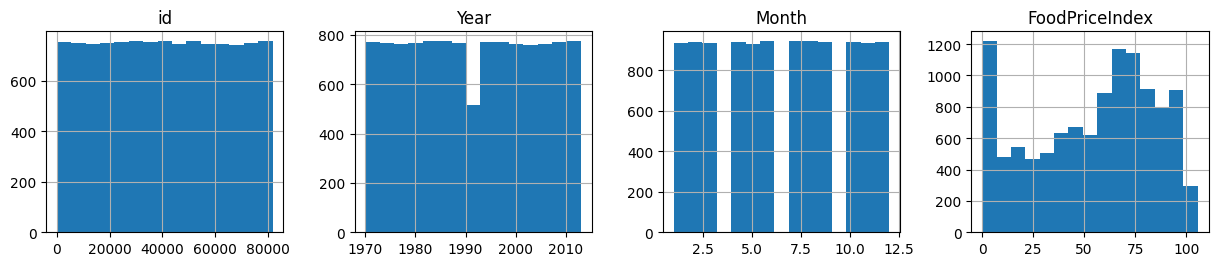

In [13]:
train[num_cols].hist(bins=15, figsize=(15, 6), layout=(2, 4));

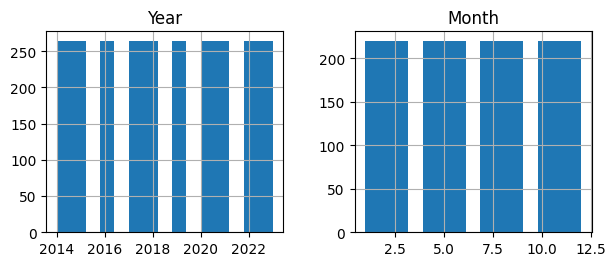

In [14]:
test[['Year', 'Month']].hist(bins=15, figsize=(15, 6), layout=(2, 4));

Might need to scale our data

### Heatmap Correlation

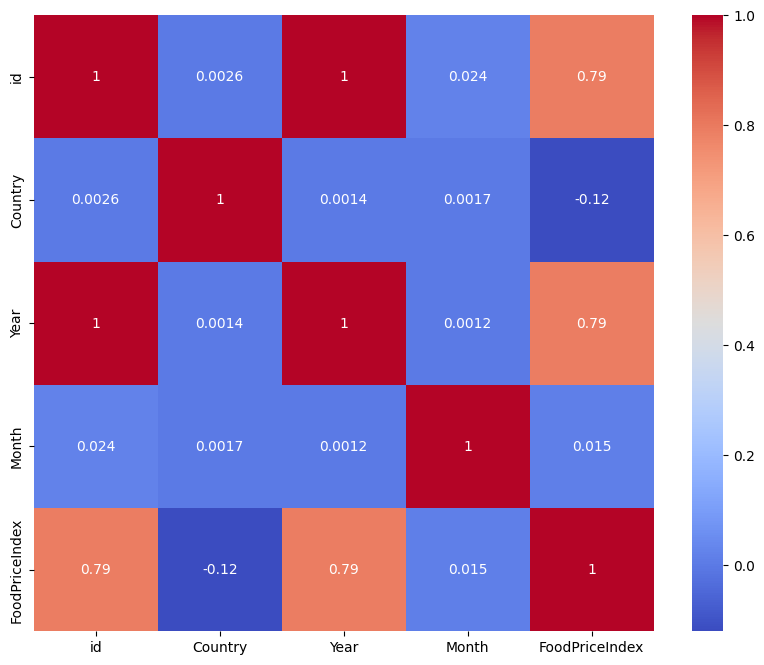

In [15]:
le = LabelEncoder()

train2 = train.copy()

train2['Country'] = le.fit_transform(train2['Country'])

corr_mat = train2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.show()

Yang paling berpengaruh dengan `FoodIndex` hanya Year dengan hasil korelasi pearson 0.79.

Method yang bisa diuji (Time Series Forecasting):
- Arima
- Prophet
- RandomForestRegressor

### Boxplot

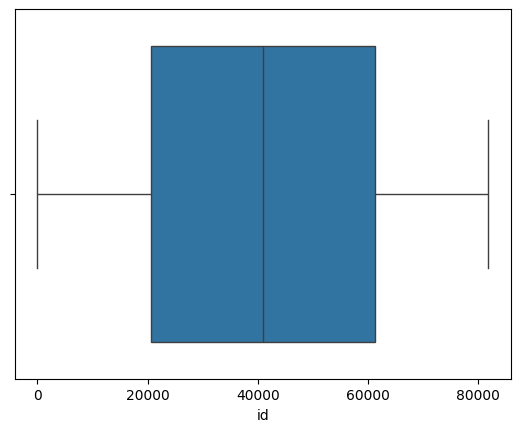

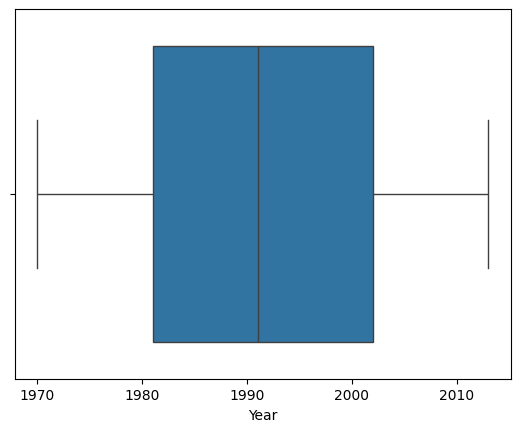

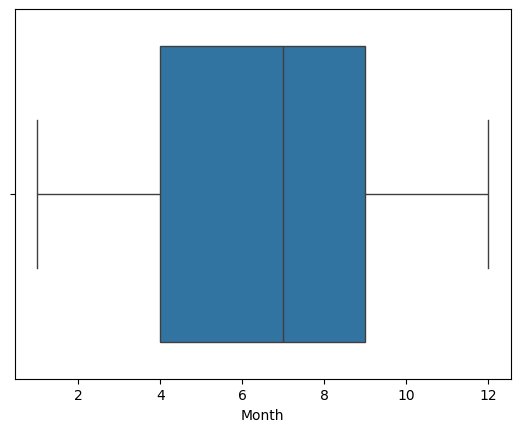

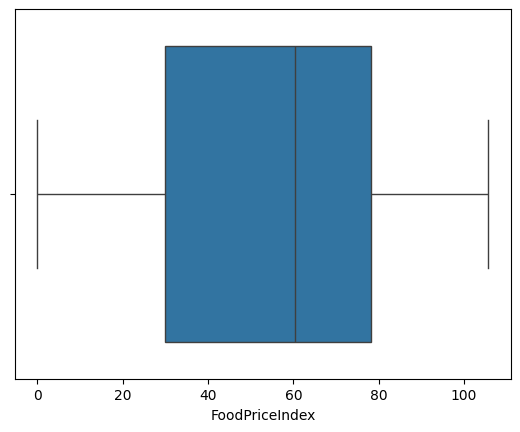

In [16]:
for col in num_cols:
    sns.boxplot(x=train[col])
    plt.show()

No need to handle outlier, karena data kita juga terdistribusi uniform.

## Modelling

In [97]:
X = train.drop(columns=['FoodPriceIndex', 'id'])
y = train['FoodPriceIndex']

In [99]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9014, 3), (2254, 3), (9014,), (2254,))

In [100]:
te = ce.TargetEncoder(cols=['Country'])
X_train = te.fit_transform(X_train, y_train)
X_val = te.transform(X_val)

Evaluasi metrik

In [94]:
def smape(A, F):
    denominator = np.abs(A) + np.abs(F)
    numerator = 2 * np.abs(F - A)
    
    # Menambahkan pengecekan agar denominator tidak 0
    denominator = np.where(denominator == 0, np.finfo(float).eps, denominator)  # Gantilah 0 dengan nilai epsilon
    return 100 * np.mean(numerator / denominator)

In [104]:
# Sort data by Year and Month to ensure time series order
X_train_sorted = pd.concat([y_train, X_train], axis=1).sort_values(['Year', 'Month'])
X_val_sorted = pd.concat([y_val, X_val], axis=1).sort_values(['Year', 'Month'])

sMAPE: 1.25%


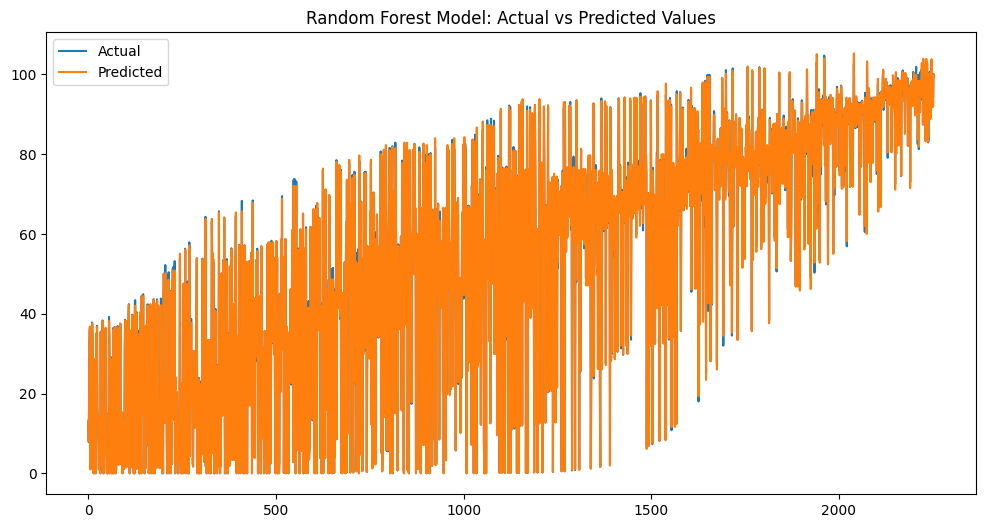


Feature Importance:
   feature  importance
1     Year    0.657616
0  Country    0.341538
2    Month    0.000846


In [105]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=1, random_state=98)
rf_model.fit(X_train_sorted[['Country', 'Year', 'Month']], X_train_sorted['FoodPriceIndex'])

# Make predictions
rf_predictions = rf_model.predict(X_val_sorted[['Country', 'Year', 'Month']])

# Calculate sMAPE
smape_rf = smape(X_val_sorted['FoodPriceIndex'].values, rf_predictions)
print(f'sMAPE: {smape_rf:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_val_sorted['FoodPriceIndex'].values, label='Actual')
plt.plot(rf_predictions, label='Predicted')
plt.title('Random Forest Model: Actual vs Predicted Values')
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': ['Country', 'Year', 'Month'],
    'importance': rf_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
sMAPE: 1.13%


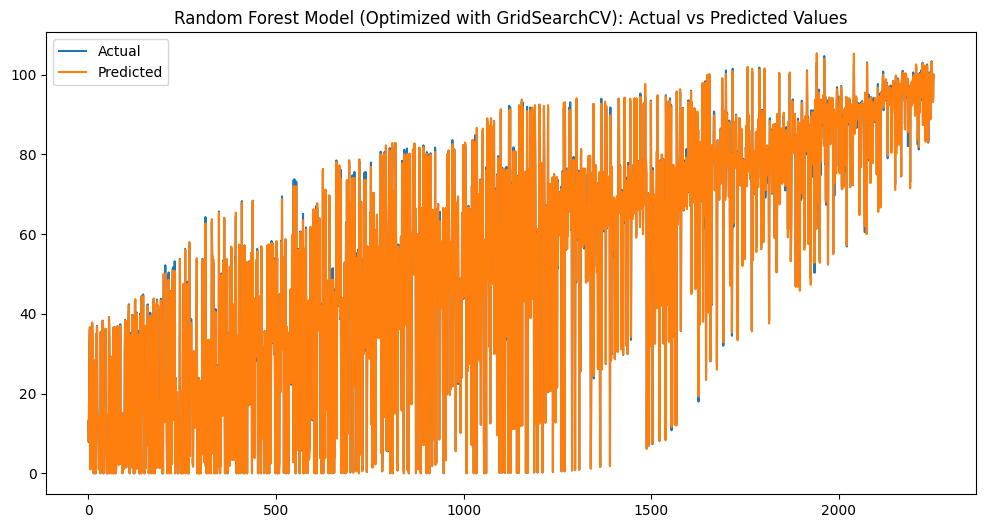


Feature Importance (Optimized Model):
   feature  importance
1     Year    0.657267
0  Country    0.341875
2    Month    0.000858


In [110]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],       # Jumlah estimators (pohon)
    'max_depth': [None, 10, 20, 30],      # Kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10],      # Jumlah minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],        # Jumlah minimum sampel di leaf node
    'bootstrap': [True, False]            # Apakah bootstrap digunakan
}
# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=98)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Fit GridSearchCV to the data
grid_search.fit(X_train_sorted[['Country', 'Year', 'Month']], X_train_sorted['FoodPriceIndex'])

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
rf_predictions = best_rf_model.predict(X_val_sorted[['Country', 'Year', 'Month']])

# Calculate sMAPE
smape_rf = smape(X_val_sorted['FoodPriceIndex'].values, rf_predictions)
print(f'sMAPE: {smape_rf:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_val_sorted['FoodPriceIndex'].values, label='Actual')
plt.plot(rf_predictions, label='Predicted')
plt.title('Random Forest Model (Optimized with GridSearchCV): Actual vs Predicted Values')
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': ['Country', 'Year', 'Month'],
    'importance': best_rf_model.feature_importances_
})
print("\nFeature Importance (Optimized Model):")
print(feature_importance.sort_values('importance', ascending=False))

In [111]:
rf_predictions

array([ 13.2,   8. ,  20.8, ...,  93.2, 100. ,  99.3])

In [112]:
# Check for zero or NaN values in actual values
zero_mask = X_val_sorted['FoodPriceIndex'] == 0
print(f"Zero values in actuals: {X_val_sorted['FoodPriceIndex'][zero_mask].shape[0]}")

# Check for NaN values in actual and predicted values
print(f"NaN values in actuals: {X_val_sorted['FoodPriceIndex'].isna().sum()}")
print(f"NaN values in predictions: {np.isnan(rf_predictions).sum()}")

# Check if actual and predicted values have the same length
print(f"Length of actuals: {len(X_val_sorted['FoodPriceIndex'])}")
print(f"Length of predictions: {len(rf_predictions)}")

# Inspect predictions to ensure they're not constant or unrealistic
print(f"Sample of predictions: {rf_predictions[:10]}")


Zero values in actuals: 103
NaN values in actuals: 0
NaN values in predictions: 0
Length of actuals: 2254
Length of predictions: 2254
Sample of predictions: [13.2     8.     20.8    32.9    36.6974  1.     16.3     1.4    36.6974
  8.    ]


In [113]:
# Filter out zero actual values
non_zero_mask = X_val_sorted['FoodPriceIndex'] != 0

# Apply the mask to both actual and predicted values
smape_rf = smape(X_val_sorted['FoodPriceIndex'][non_zero_mask].values, 
                 rf_predictions[non_zero_mask])

print(f'sMAPE: {smape_rf:.2f}%')


sMAPE: 1.09%


## Apply to test set

In [ ]:
test.drop('id', axis=1, inplace=True)
test.head()

In [116]:
# apply target encoding to test data
test = te.transform(test)
test.head()

,Country,Year,Month
0,52.708049,2023,4
1,59.943839,2022,7
2,55.878469,2019,6
3,71.744059,2021,2
4,52.708049,2019,8


In [117]:
# apply predictions
test['FoodPriceIndex'] = best_rf_model.predict(test)
test

,Country,Year,Month,FoodPriceIndex
0,52.708049,2023,4,98.7
1,59.943839,2022,7,99.8
2,55.878469,2019,6,96.3
3,71.744059,2021,2,98.4
4,52.708049,2019,8,100.8
...,...,...,...,...
2635,61.501546,2022,2,100.3
2636,59.943839,2020,4,99.9
2637,43.888835,2017,1,100.0
2638,43.888835,2020,3,100.5


## Submit

In [119]:
submission = pd.read_csv('sample_submission_adikara2024.csv')
submission.head()

,id,FoodPriceIndex
0,99116,20.5
1,97687,20.5
2,92061,20.5
3,95122,20.5
4,92296,20.5


In [120]:
submission['FoodPriceIndex'] = test['FoodPriceIndex']
submission

,id,FoodPriceIndex
0,99116,98.7
1,97687,99.8
2,92061,96.3
3,95122,98.4
4,92296,100.8
...,...,...
2635,96922,100.3
2636,93502,99.9
2637,87476,100.0
2638,93366,100.5


In [121]:
submission.to_csv("submission_raw_rf_with_grid.csv", index=False)